In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
import CMS_lumi, tdrstyle

a = tdrstyle.setTDRStyle()


print(sys.version)

Welcome to JupyROOT 6.22/02
3.6.8 (default, Apr  2 2020, 13:34:55) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [4]:
fpath =OrderedDict()
tree = OrderedDict()
mass = [15, 40, 55]
# mass = [15]
# VBFH = 0
# decay = 'dddd'

# mass = [7, 15, 40, 55]
# VBFH=1
# decay = 'bbbb'


prod = ['ggH', 'VBFH', 'ZH', 'WH', 'ttH_H','ggZH']
# prod = ['ggZH']
decay = 'dddd' #no vbfh generated
# prod = ['ggH','VBFH']
decay = 'bbbb'
production = 'ZH'
mass = [15, 40, 55]
category = 0
if not decay == 'bbbb': mass = [7, 15, 40, 55]
OLD_CTAU = np.array([100, 1000, 10000, 100000])#in mm


mass = [15]
OLD_CTAU = np.array([100000])
ntupler_version = 'V1p17/'

# data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2018/v5/v66/normalized/'

# fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root'
mc_path = {}
analyzer_version = 'v1/v77/'

mc_path['ggH'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Fall18/'+analyzer_version+'/normalized/'
mc_path['VBFH'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Fall18/'+analyzer_version+'/normalized/'

analyzer_version = 'v1/v77/'


mc_path['ZH'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Fall18/'+analyzer_version+'/normalized/'
mc_path['WH'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Fall18/'+analyzer_version+'/normalized/'
mc_path['ttH_H'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Fall18/'+analyzer_version+'/normalized/'
analyzer_version = 'v2/v77/'

mc_path['ggZH'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Fall18/'+analyzer_version+'/normalized/'




for m in mass:
    for ct in OLD_CTAU:
        for p in prod:
            if p == 'VBFH' and decay == 'bbbb':
                key = 'MC_'+p+'_'+str(m)+'_'+str(ct) 
                fpath[p] = mc_path[p]+p+'_HToSSTo4b_MH-125_MS-55.root'
#                 fpath[p] = mc_path[p]+p+'_HToSSTo4b_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_TuneCP5_13TeV-powheg-pythia8_137000pb_weighted.root'
            elif p == 'ggH' or p == 'VBFH':
                key = 'MC_'+p+'_'+str(m)+'_'+str(ct)                       
                fpath[p] = mc_path[p]+p+'_HToSSTo'+decay+'_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_TuneCP5_13TeV-powheg-pythia8_137000pb_weighted.root'
            elif p == 'ZH' or p == 'ttH_H':
                fpath[p] = mc_path[p] + p+'ToSS_SToBB.root'
            elif p == 'ggZH':
#                 fpath[p] = mc_path[p]+'ggZHToSS_SToBB_ms40_pl1000_137000pb_weighted.root'
                fpath[p] = mc_path[p]+'ggZHToSS_SToBB_137000pb_weighted.root'
            else:
                key = 'MC_'+p+'_'+str(m)+'_'+str(ct)                       
                fpath[p] = mc_path[p] + p+'ToSS_SToBB_ms'+str(m)+'_pl'+str(ct)+'_137000pb_weighted.root'
                
NEvents = {}
NEvents_genweight = {}
gHiggsPt = {}
gHiggsEta = {}
w = {}
for k,v in fpath.items():
    
    root_dir = uproot.open(v) 
    if not root_dir: 
        print(k, "zombie")
        continue
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    w[k] = tree[k]["weight"].array()
    if k == 'ggH': w[k] *= tree[k]['higgsPtWeight'].array()
    elif k == 'ttH_H' or k == 'ZH':w[k] = w[k]/12
    elif k == 'VBFH':w[k] = w[k]/13
    elif k == 'ggZH':w[k] = w[k]/9.38932
    gHiggsPt[k] = tree[k]['gHiggsPt'].array()
    gHiggsEta[k] = tree[k]['gHiggsEta'].array()


    
    
    if not 'data' in k: 
        print(k, len(w[k]))
#         print(k,np.mean(w))

legend = {
'MC_ggH_15_1000': 'ggH',
'MC_VBFH_15_1000': 'VBFH',
'MC_ZH_15_1000': 'ZH',
'MC_WH_15_1000': 'WH',
'MC_ttH_H_15_1000': 'ttH'

}

ggH 3112000
VBFH 6648196
ZH 4121854
WH 1210293
ttH_H 2357200
ggZH 2877769


Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/higgsPt/higgsPt_withggZH.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/higgsPt/higgsPt_withggZH.C has been generated


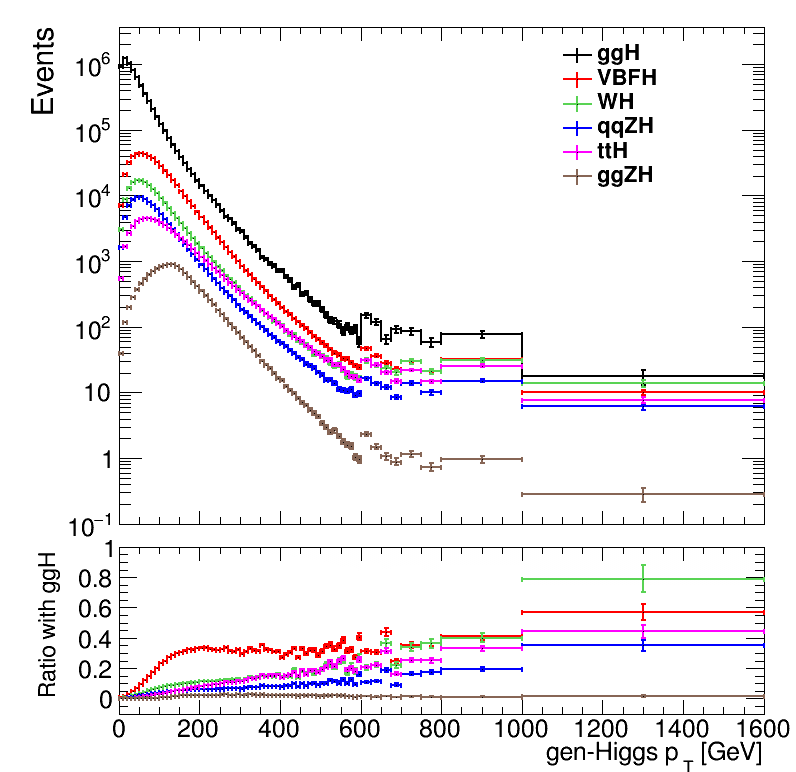

In [7]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot


leg = rt.TLegend(0.75,0.72,0.90,0.90)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 1000, 800)
bins_pt = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230,
  240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460,
  470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 625, 650, 675, 700, 750, 800, 1000, 1600]
bins_eta = list(np.arange(-5,5,0.2))

bins_pt = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230,
  240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460,
  470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 625, 650, 675, 700, 750, 800, 1000, 1600]
bins_eta = list(np.arange(0,3,0.25))+[3,4,5]
h = {}
rt.gStyle.SetOptFit(1011)
for i,k in enumerate(gHiggsPt.keys()):
#     if not 'ggH' in k:continue
    if 'data' in k:continue
    h[k] = create_TH1D( gHiggsPt[k], axis_title=['gen-Higgs p_{T} [GeV]', 'Events'], name='h', binning=bins_pt, weights = w[k])
#     h[k] = create_TH1D( np.abs(gHiggsEta[k]), axis_title=['gen-Higgs #eta', 'Events'], name='h', binning=bins_eta, weights = w[k])
#     h[k] = create_TH2D( np.column_stack((gHiggsPt[k],np.abs(gHiggsEta[k]))), axis_title=['pT','gen-Higgs #eta', 'Events'], name='h', binning=bins_pt+bins_eta+[len(bins_pt),len(bins_eta)], weights = w[k])


#     for j in range(h[k].GetNbinsX()):
#         for l in range(h[k].GetNbinsY()):
# #             if h[k].GetBinContent(j+1,l+1) ==0:
# #                 print(k,h[k].GetXaxis().GetBinCenter(j+1), h[k].GetYaxis().GetBinCenter(l+1), h[k].GetBinContent(j+1,l+1))
#             if h[k].GetBinContent(j+1,l+1)>0 and h[k].GetBinError(j+1,l+1)/h[k].GetBinContent(j+1,l+1)> 0.1:
#                 print(k,h[k].GetXaxis().GetBinCenter(j+1), h[k].GetYaxis().GetBinCenter(l+1), h[k].GetBinError(j+1,l+1)/h[k].GetBinContent(j+1,l+1))
#         if h[k].GetBinError(j+1)/h[k].GetBinContent(j+1) > 0.1:
#         print(k,h[k].GetBinCenter(j+1), h[k].GetBinError(j+1)/h[k].GetBinContent(j+1))
    h[k].SetLineColor(std_color_list[i])
    leg.AddEntry(h[k],k)
    h[k].SetMaximum(1000000)
    h[k].DrawNormalized('same hist')
#     h[k].Draw('colz')


h_reweight= h['ggZH'].Clone()
# h_reweight.Divide(h['ggH'])
source_mode = 'ttH_H'
source = h[source_mode].Clone()
target = h['ggZH'].Clone()
for j in range(h['ggH'].GetNbinsX()):
    for l in range(h['ggH'].GetNbinsY()):
        if source.GetBinContent(j+1,l+1) > 0:h_reweight.SetBinContent(j+1,l+1,1.0*target.GetBinContent(j+1,l+1)/source.GetBinContent(j+1,l+1))
        elif target.GetBinContent(j+1,l+1)==0:h_reweight.SetBinContent(j+1,l+1,0)
        else:h_reweight.SetBinContent(j+1,l+1, h_reweight.GetBinContent(j+1,l))
        

if len(prod)==6:
    c = make_ratio_plot([h['ggH'],h['VBFH'],h['WH'],h['ZH'],h['ttH_H'], h['ggZH']], fit = False, logy=True, in_tags = ['ggH','VBFH','WH','qqZH','ttH','ggZH'], \
                        ratio_bounds = [-0.1,1.0], ratio_index = 0, draw_opt = ['E1','E1','E1','E1','E1','E1']) 
elif len(prod) == 5:
    c = make_ratio_plot([h['ggH'],h['VBFH'],h['WH'],h['ZH'],h['ttH_H']], fit = False, logy=True, in_tags = ['ggH','VBFH','WH','ZH','ttH'], \
                        ratio_bounds = [-0.1,1.0], ratio_index = 0, draw_opt = ['E1','E1','E1','E1','E1']) 
c.SetRightMargin(0.1)
c.SetRightMargin(0.2)

# c.SetLogy()
c.SetLogz()
# leg.Draw()
if len(prod)==6:
    c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/higgsPt/higgsPt_withggZH.png')
    c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/higgsPt/higgsPt_withggZH.C')
elif len(prod) == 5:
    c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/higgsPt/higgsPt.png')
    c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/higgsPt/higgsPt.C')
c.Draw()



In [64]:
outputDir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/HiggsPtWeights/'

outputFileName = outputDir + source_mode+'ToggZH_HiggsPtReweight.root'
outFile = rt.TFile(outputFileName, 'RECREATE')

outFile.WriteTObject(h_reweight, 'higgsPthiggsEta', "WriteDelete");
outFile.Close();